# Modelo de regresión lineal
## Ejercicio de aplicación a consumo de gas en Buenos Aires (Argentina)

In [1]:
## Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import sklearn.linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.dates as mdate
import datetime as dt

%matplotlib inline

## Cargar y normalizar datos meteorológicos
Fuente de datos climáticos: 
[NASA (POWER Data Access Viewer)](https://power.larc.nasa.gov/data-access-viewer/) <br>
Fuente de datos consumo de gas: 
[ENARGAS](https://www.enargas.gob.ar/secciones/transporte-y-distribucion/datos-operativos-subsec.php?sec=1&subsec=6&subsecord=06)

In [2]:
# Load data
filepath = './Regresion'

filename_climate = 'POWER_SinglePoint_Daily_19930101_20200712_34d59S_58d42W_cb0244f8.csv'
filename_gasm3 = 'Todos_010601a-Cuadro_I_5_1a.xlsx'
filename_gasN = 'Todos_010601b-Cuadro_I_5_1b.xlsx'

In [3]:
df = pd.read_csv(filepath + '/' + filename_climate, skiprows = 16)
df.replace(-999, value = 0)
df['T2M_MED'] = ((df['T2M_MAX'] + df['T2M_MIN'])/ 2).round(1)
df['GD'] = np.where(df['T2M_MED'] <= 20, (20 - df['T2M_MED']), 0).round(0)

df.columns = ['Lat', 'Lon', 'Year', 'Month', 'Day', 'TMax', 'TMin', 'RHum', 'Prec', 'Pres', 'Wind', 'Rad', 'TMed', 'GD']
df.head()

Lat       Lon  Year  Month  Day   TMax   TMin   RHum  Prec    Pres  \
0 -34.58999 -58.41999  1993      1    1  26.62  18.67  65.58  0.11  101.74   
1 -34.58999 -58.41999  1993      1    2  28.16  18.58  66.69  0.02  101.31   
2 -34.58999 -58.41999  1993      1    3  29.13  19.20  65.86  0.00  101.05   
3 -34.58999 -58.41999  1993      1    4  31.36  20.48  62.28  0.24  100.67   
4 -34.58999 -58.41999  1993      1    5  32.65  20.87  60.31  1.66  100.48   

   Wind   Rad  TMed   GD  
0  8.47  8.16  22.6  0.0  
1  4.84  8.96  23.4  0.0  
2  4.07  8.19  24.2  0.0  
3  3.00  8.38  25.9  0.0  
4  2.98  8.42  26.8  0.0

In [4]:
df_mes = pd.pivot_table(df, values = ['GD', 'Prec'], index = ['Year', 'Month'], aggfunc='sum')
df_mes1 = pd.pivot_table(df, values = ['TMed', 'RHum', 'Pres', 'Wind', 'Rad'], index = ['Year', 'Month'], aggfunc='mean')

df_mes1['Pres'] = df_mes1['Pres'] * 10

df_mes['TMed'] = df_mes1['TMed'].values.round(1)
df_mes['RHum'] = df_mes1['RHum'].values.round(1)
df_mes['Pres'] = df_mes1['Pres'].values.round(2)
df_mes['Wind'] = df_mes1['Wind'].values.round(2)
df_mes['Rad'] = df_mes1['Rad'].values.round(2)

df_mes = df_mes.iloc[:324]
df_mes

GD    Prec  TMed  RHum     Pres  Wind     Rad
Year Month                                                  
1993 1        0.0  116.28  24.6  64.8  1008.25  4.43    8.27
     2       12.0  155.52  22.2  73.4  1011.97  4.75    7.12
     3        4.0   90.17  22.5  72.4  1012.93  4.19    6.43
     4       68.0  187.08  18.2  80.5  1012.57  5.26    4.82
     5      195.0  100.19  13.7  81.7  1013.79  4.68    3.73
...           ...     ...   ...   ...      ...   ...     ...
2019 8      279.0   36.58  11.0  78.5  1020.57  4.71 -610.76
     9      202.0   31.78  13.2  72.7  1016.79  4.83 -496.62
     10     121.0  180.93  16.2  76.5  1014.60  5.46 -674.34
     11      16.0   52.61  21.1  68.9  1011.53  5.03 -394.58
     12       7.0  104.54  22.7  60.6  1009.82  4.71 -413.71

[324 rows x 7 columns]

## Cargar y normalizar datos de consumo de gas por usuario

In [5]:
dfm3 = pd.read_excel(filepath + '/' + filename_gasm3, header = 9, nrows = 324)
dfm3 = dfm3[['Mes', 'Capital Federal']]

dfusuarios = pd.read_excel(filepath + '/' + filename_gasN, header = 9, nrows = 324)
dfusuarios = dfusuarios[['Capital Federal']]

dfm3['usuarios'] = dfusuarios['Capital Federal'].values
dfm3['usuariomed'] = ((dfm3['Capital Federal'] * 1000) / dfm3['usuarios']).round(2)
dfm3

Mes  Capital Federal  usuarios  usuariomed
0   1993-01-01            37718   1165131       32.37
1   1993-02-01            32390   1165150       27.80
2   1993-03-01            49946   1157799       43.14
3   1993-04-01            51587   1157800       44.56
4   1993-05-01           122670   1163042      105.47
..         ...              ...       ...         ...
319 2019-08-01           135471   1403985       96.49
320 2019-09-01            98220   1404299       69.94
321 2019-10-01            85060   1404572       60.56
322 2019-11-01            42944   1404847       30.57
323 2019-12-01            40994   1405130       29.17

[324 rows x 4 columns]

In [6]:
df_mes['Mes'] = dfm3['Mes'].values
df_mes['Gas'] = dfm3['usuariomed'].values.round(2)
df = df_mes[['Mes', 'TMed', 'GD', 'Wind', 'Prec', 'Rad', 'RHum', 'Pres', 'Gas']]
#df = df[df['Mes'] >= '2000-01-01']
df.reset_index(drop=True, inplace=True)
df

Mes  TMed     GD  Wind    Prec     Rad  RHum     Pres     Gas
0   1993-01-01  24.6    0.0  4.43  116.28    8.27  64.8  1008.25   32.37
1   1993-02-01  22.2   12.0  4.75  155.52    7.12  73.4  1011.97   27.80
2   1993-03-01  22.5    4.0  4.19   90.17    6.43  72.4  1012.93   43.14
3   1993-04-01  18.2   68.0  5.26  187.08    4.82  80.5  1012.57   44.56
4   1993-05-01  13.7  195.0  4.68  100.19    3.73  81.7  1013.79  105.47
..         ...   ...    ...   ...     ...     ...   ...      ...     ...
319 2019-08-01  11.0  279.0  4.71   36.58 -610.76  78.5  1020.57   96.49
320 2019-09-01  13.2  202.0  4.83   31.78 -496.62  72.7  1016.79   69.94
321 2019-10-01  16.2  121.0  5.46  180.93 -674.34  76.5  1014.60   60.56
322 2019-11-01  21.1   16.0  5.03   52.61 -394.58  68.9  1011.53   30.57
323 2019-12-01  22.7    7.0  4.71  104.54 -413.71  60.6  1009.82   29.17

[324 rows x 9 columns]

## Graficar relación entre variables
Las gráficas bivariantes ayudan a comprender las relaciones que se establecen entre los datos.
Las primeras gráficas abordarán la totalidad de las variables, en una matrix de gráficas de dispersión/histogramas, y una matriz de correlación.
Se hará énfasis en mostrar las relaciones más estrechas entre las variables climáticas y el consumo de gas.

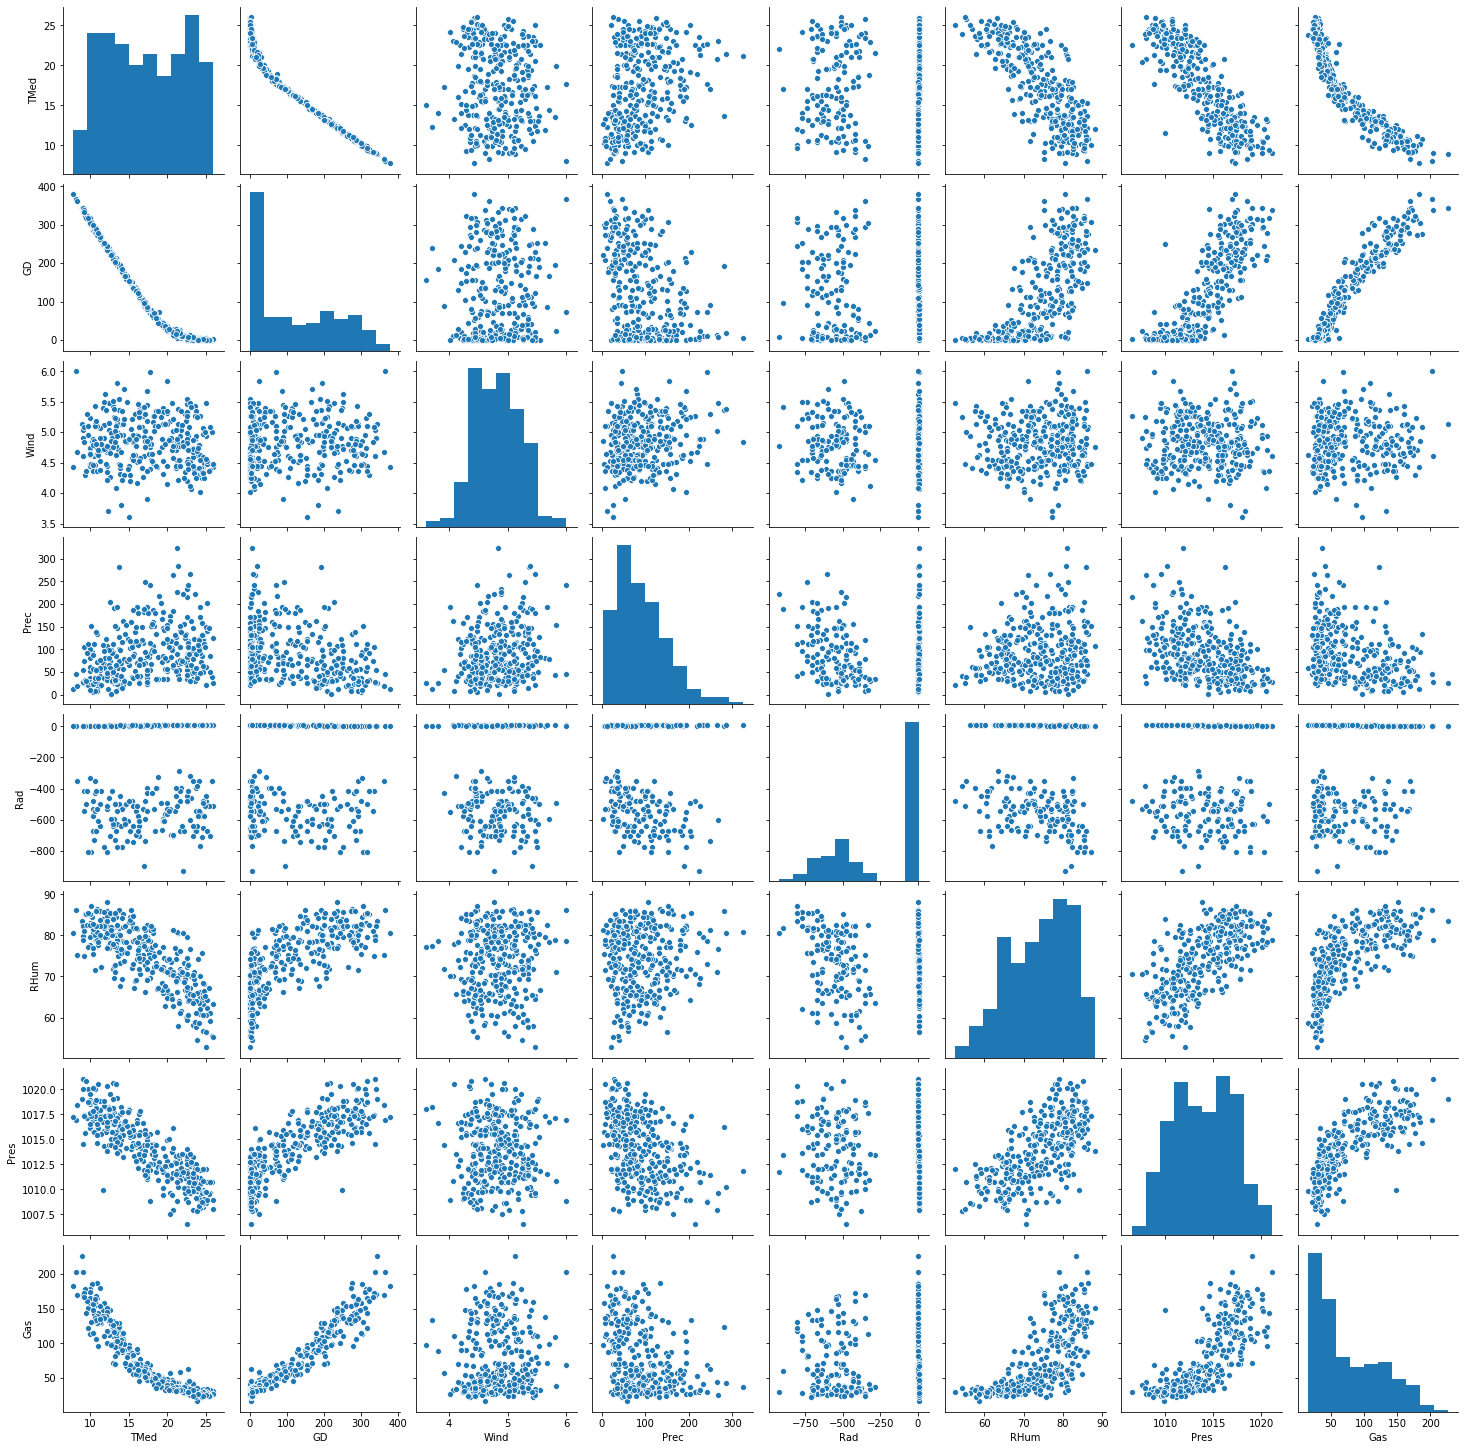

In [7]:
sns.pairplot(df)

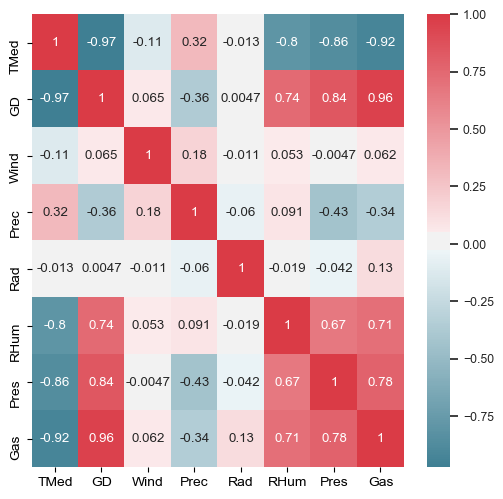

In [8]:
plt.subplots(figsize=(6,6), dpi=100)
sns.set(font_scale=0.8)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(df.corr(), annot = True, cmap = cmap)

Se observan en rojo las relaciones positivas y en azul las relaciones inversas. Las relaciones en blanco o más pálidas, son relaciones que no se puede afirmar que estén condicionadas.
La relación que nos interesa es la de la última columna, que es la relación del consumo de gas del usuario medio con las variables. Allí podemos observar que:
* La temperatura media posee una correlación inversa del 0.92 con el consumo de gas.
* Los grados día de calefacción calculados poseen una correlación positiva del 0.96 con el consumo de gas.
* No existe una relación clara entre la velocidad del viento, las precipitaciones mensuales y la radiación media incidente en una superficie horizontal y el consumo de gas.
* Existe una relación positiva del 0.71 entre el consumo de gas y la humedad relativa, lo que tiene sentido dada su relación inversa con la temperatura (-0.8 de correlación).
* Existe una relación positiva del 0.78 entre el consumo de gas y la presión, lo que tiene sentido dada su relación inversa con la temperatura por el movimiento de las masas de aire (-0.86 de correlación).

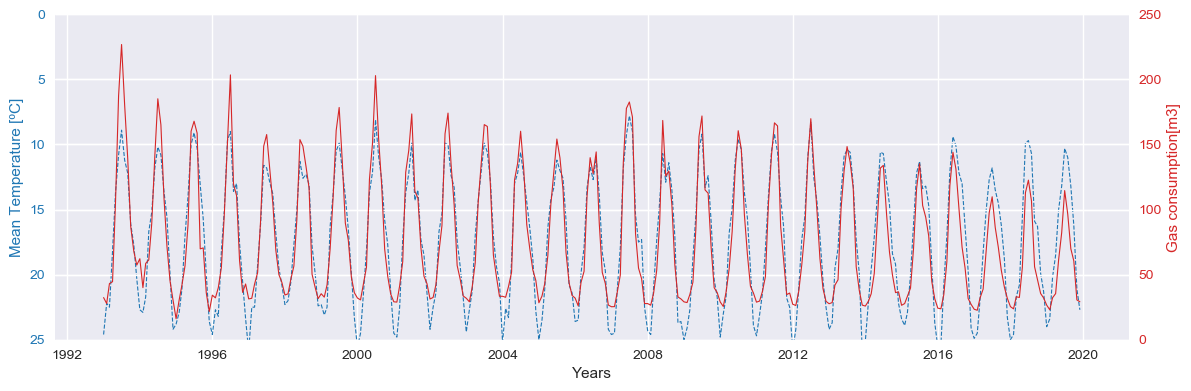

In [9]:
plt.style.use('seaborn')

t = df['Mes']
data1 = df['TMed']
data2 = df['Gas']

fig, ax1 = plt.subplots(figsize=(12,4), dpi=100)

# x axis
color = 'tab:blue'
ax1.set_xlabel('Years')

# y1 axis
ax1.set_ylabel('Mean Temperature [ºC]', color=color)
ax1.plot(t, data1, color=color, lw=0.8, linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([25, 0])

# y2 axis
ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('Gas consumption[m3]', color=color)  
ax2.plot(t, data2, color=color, lw=0.8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 250])

fig.tight_layout()  

Para poder observar de manera más gráfica la relación inversa entre temperatura y consumo de gas, se ha invertido la escala de temperatura en el eje.

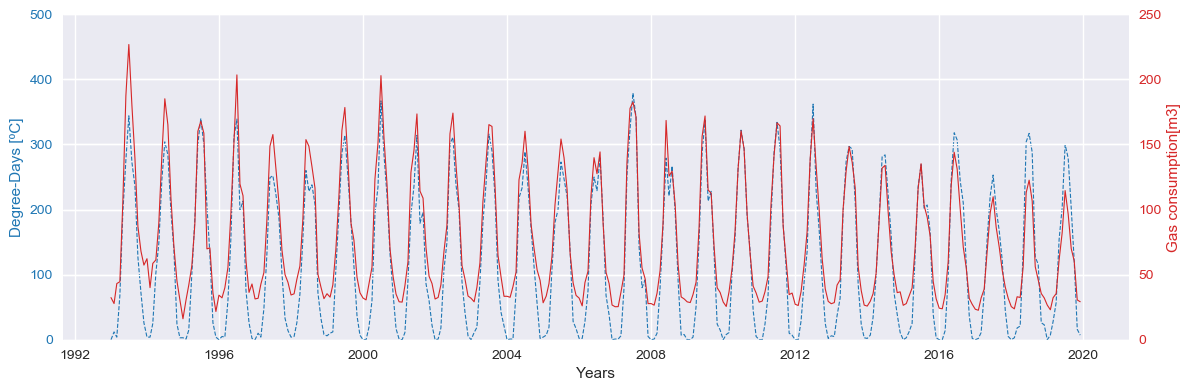

In [10]:
plt.style.use('seaborn')

t = df['Mes']
data1 = df['GD']
data2 = df['Gas']

fig, ax1 = plt.subplots(figsize=(12,4), dpi=100)

# x axis
color = 'tab:blue'
ax1.set_xlabel('Years')

# y1 axis
ax1.set_ylabel('Degree-Days [ºC]', color=color)
ax1.plot(t, data1, color=color, lw=0.8, linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 500])

# y2 axis
ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('Gas consumption[m3]', color=color)  
ax2.plot(t, data2, color=color, lw=0.8)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0, 250])

fig.tight_layout()  

Spearmans correlation: -0.964


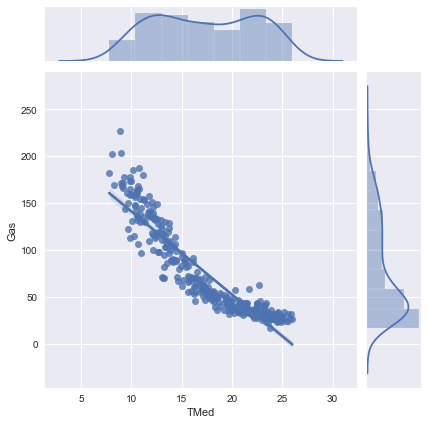

In [11]:
sns.jointplot(x='TMed',y='Gas',data=df,kind='reg')

corr, _ = spearmanr(df['TMed'], df['Gas'])
print('Spearmans correlation: %.3f' % corr)

Spearmans correlation: 0.958


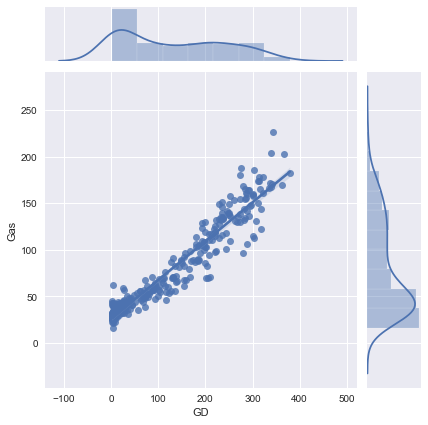

In [12]:
df1 = df[df['GD'] != 0]

sns.jointplot(x='GD',y='Gas',data=df1,kind='reg')

corr, _ = spearmanr(df1['GD'], df1['Gas'])
print('Spearmans correlation: %.3f' % corr)

## Modelo de regresión lineal
La regresión lineal es un enfoque lineal para modelar la relación entre una respuesta escalar (o variable dependiente) y una o más variables explicativas (o variables independientes).
En la regresión lineal, las relaciones se modelan utilizando funciones de predicción lineal cuyos parámetros de modelo desconocidos se estiman a partir de los datos. Tales modelos se llaman modelos lineales.

### Entrenamiento del modelo

In [13]:
# X and Y arrays
X = df[['TMed', 'GD', 'Pres', 'RHum']]
y = df['Gas']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#creating and training the model
lm = LinearRegression()
lm.fit(X_train,y_train)

#model evaluation
print(lm.intercept_)

751.1078916423633


In [14]:
coeff_df = pd.DataFrame(lm.coef_, index = X.columns, columns = ['Coefficient'])
coeff_df

Coefficient
TMed     2.299275
GD       0.524492
Pres    -0.783133
RHum     0.223634

Interpretación de los coeficientes:
Manteniendo todas las variables fijas, un incremento de 1 en... <br>
...**Temperatura media (ºC)** está asociado a un **incremento de 2.29m3** de consumo de gas por usuario. <br>
...**Grados-día de calefacción (ºC)** está asociado a un **incremento de 0.52m3** de consumo de gas por usuario. <br>
...**Presión atmosférica media (hPa)** está asociado a una **reducción de 0.78m3** de consumo de gas por usuario. <br>
...**Humedad relativa media (%)** está asociado a un **incremento de 0.22m3** de consumo de gas por usuario. <br>

### Predicciones

In [15]:
predictions = lm.predict(X_test)

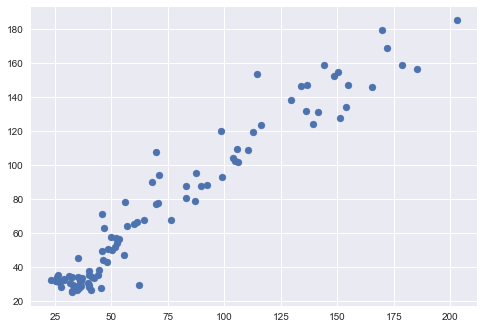

In [16]:
plt.scatter(y_test,predictions)

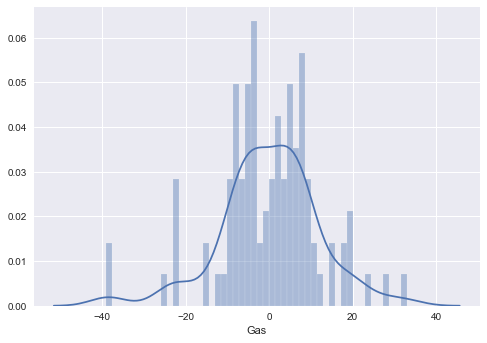

In [17]:
sns.distplot((y_test-predictions),bins=50);

In [18]:
MAE = metrics.mean_absolute_error(y_test, predictions)
MSE = metrics.mean_squared_error(y_test, predictions)
RMSE = np.sqrt(metrics.mean_squared_error(y_test, predictions))

print('MAE:', MAE)
print('MSE:', MSE)
print('RMSE:', RMSE)

MAE: 8.879188565994204
MSE: 141.46621860758492
RMSE: 11.893957230778364


In [19]:
print(min(df['Gas']))
print(max(df['Gas']))
print(max(df['Gas']) - min(df['Gas']))

16.11
226.79
210.68


In [20]:
print('MAE:',MAE/ (max(df['Gas']) - min(df['Gas'])))
print('RMSE:',RMSE/(max(df['Gas']) - min(df['Gas'])))

MAE: 0.04214537956139265
RMSE: 0.05645508463441411


En un ejercicio simple para tratar de predecir el consumo de gas de acuerdo a las condiciones climáticas, el error predictivo del modelo es muy bajo por la estrecha correlación existente entre las variables explicativas (Temperatura, Grados-día de calefacción, Presión atmosférica, Humedad Relativa) y la respuesta escalar (Consumo de gas).